In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pygmsh
import math as m
import scipy.integrate as integrate
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import splu
from scipy.special import hankel1
from scipy.special import jv, jvp  # jv(order, x), jvp(order, x) derivative wrt argument


## Helmholtz Problem

We consider the boundary value problem:

$$
\begin{cases}
\Delta u + k^2 u = 0 & \text{in } \Omega_N = B_N \setminus \Omega, \\
u = f & \text{on } \Gamma = \partial \Omega, \\
\dfrac{\partial u}{\partial n} = g & \text{on } S_N = \partial B_N.
\end{cases}
$$

where

$$
B_N = \{(x, y) \in \mathbb{R}^2 : x^2 + y^2 < r\}, \quad (r > 1),
$$  

and $\Omega \subset \mathbb{R}^2$ is the polygonal domain with vertices

$$
(x_j, y_j) = r_j (\cos \theta_j, \sin \theta_j), \quad \theta_j = \frac{2\pi}{10}(j-2),
$$  

$$
r_{2j-1} = 1, \quad r_{2j} = \tfrac{1}{2}, \quad j = 1, \ldots, 10.
$$

---

### Variational Formulation

We consider the space
  $$
  V := \mathring H^1(\Omega_N) = \{\, v \in H^1(\Omega_N) : \gamma_\Gamma v = 0 \,\}.
  $$

where $\gamma_\Gamma$ denotes the trace operator on $\Gamma$. Next, we define 
$a: V \times V \mapsto \mathbb{K}$ amd $\ell: V \mapsto \mathbb{K}$

$$
a(u,v) := -\int_{\Omega_N} \nabla u \cdot \nabla v \, dx + k^2 \int_{\Omega_N} u\,v \, dx,
$$

$$
\ell(v) := -\int_{S_N} g \, \gamma_{S_N} v \, ds.
$$

This way, we obtain the variational formulation for the case of an homogeneous Dirichlet 
boundary condition over $\Gamma$, i.e. when $f=0$: Find $u \in V$ s.t.

$$
a(u,v) = \ell(v) \qquad \forall v \in V.
$$

Now, since we want allow the Dirichlet condition over $\Gamma$ to be inhomogeneous, we 
introduce a **lifting**:

* Choose a function $w \in H^1(\Omega_N)$ such that

  $$
  w|_\Gamma = f.
  $$

* Set

  $$
  u = w + \tilde{u}, \qquad \tilde{u} \in V.
  $$

Substituting into the homogeneous variational formulation gives us the weak problem: 
Find $\tilde{u} \in V$ such that

$$
a(\tilde{u}, v) = \tilde \ell(v) \qquad \forall v \in V.
$$

where, 

$$
\tilde \ell(v) := \ell(v) - a(w, v) \qquad \forall v \in V
$$

This way, we solve for $\tilde u \in V$, satisfying the homogeneous Dirichlet condition. Finally, 
we want to find a Galerkin approximation of $\tilde u$, for this so, we let $V_h \subset H^1(\Omega_N)$ 
be the Lagrange FE space $V_h \subset V$ of piecewise linear globally continuous functions. The weak 
problem no is to find $\tilde{u}_h \in V_h$, such that,

$$
a(\tilde{u}_h, v) = \tilde \ell(v) \qquad \forall v \in V_h.
$$

If $\{\phi_i\}$ is the previously introduced hat functions basis for $V_h$, then the weak form is 
equivalent to the linear system:

$$
(-K + k^2 M)\,\mathbf{\tilde{u}} = \mathbf{\tilde{b}},
$$

where,

$$
K_{ij} = \int_{\Omega_N} \nabla \phi_j \cdot \nabla \phi_i \, dx,
$$

$$
M_{ij} = \int_{\Omega_N} \phi_j \, \phi_i \, dx,
$$

$$
b_i = - \int_{S_N} g \, \phi_i \, ds.
$$

$$
\mathbf{\tilde{b}} = \mathbf{b} - (-K + k^2 M)\,\mathbf{w}
$$

and $\mathbf{w}$ are the coefficients of the lifting $w \in V$, usually chosen to vanish in the interior degrees of freedom.



In [12]:
class HelmholtzFEM:
    """
    FEM solver for the Helmholtz equation on an annular domain
    with Dirichlet BC on the inner polygon and Neumann BC on the outer circle.
    """

    def __init__(self, R=5, N=10, h=0.1, k=3.0): #, theta=-np.pi/4):
        self.m = 1
        self.R = R                                                         # Outer radius
        self.N = N                                                         # Number of vertices for polygon
        self.h = h                                                         # Target mesh size
        # self.theta = theta                                               # Wave propagation angle
        self.k = k                                                         # Wavenumber
        self.mesh = None                                                   # Will store mesh
        self.GDoF = None                                                   # Global degrees of freedom
        self.LDoF = 3                                                      # Local degrees of freedom (triangles)
        self.elements = None                                               # Triangle connectivity
        self.dirichlet_nodes_indexes = None                                # Dirichlet nodes flag
        self.neumann_nodes_indexes = None                                  # Neumann nodes flag
        self.solution = None                                               # Computed FEM solution
        self.u_exact = None                                                # Exact solution function
        self.M = None                                                      # Mass matrix
        self.S = None                                                      # Stiffness matrix
        # self.f = lambda x, y: hankel1(0, self.k * np.sqrt(x**2 + y**2))
        # self.g = lambda x, y: self.k * hankel1(1, self.k * np.sqrt(x**2 + y**2))
        # self.gR = self.k * hankel1(1, self.k * self.R)
        self.f = lambda x, y: self._u_ex(x, y)
        self.g = lambda x, y: self._dudn(x, y)
        self.u_exact = lambda x, y: self._u_ex(x, y)
        self.gauss_t = np.array([0.5 - 1/ (2*np.sqrt(3)),
                                 0.5 + 1/(2*np.sqrt(3))])
        self.gauss_w = np.array([0.5, 0.5]) 

    def _cart_to_polar(self, x, y):
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        return r, theta

    def _u_ex(self, x, y):
        r, theta = self._cart_to_polar(x, y)
        return jv(self.m, self.k*r) * np.cos(self.m*theta)

    def _dudn(self, x, y):
        # outward normal is radial unit vector
        r, theta = self._cart_to_polar(x, y)
        # radial derivative: d/dr J_m(k r) = k * J_m'(k r)  (jvp gives derivative wrt argument)
        dudr = self.k * jvp(self.m, self.k*r)
        return dudr * np.cos(self.m * theta)   # dudn = dudr because normal is radial

    def _prune_z_0(self):
        """Remove zero z-coordinate if mesh is planar."""
        if self.mesh.points.shape[1] == 3 and np.all(np.abs(self.mesh.points[:, 2]) < 1.0e-13):
            self.mesh.points = self.mesh.points[:, :2]

    def _delete_origin_aux_point(self):
        '''Eliminates the aux point on the origin (0,0), used originally 
        to create the arcs for the curved Neumann Bdd. Also, repairs element 
        indexing after eliminating this point, since all elements are 
        originally indexed considering the origin point
        
        --
        
        This function is highly inefficient, however meshing is not a special 
        central topic of this bootcamp.
        '''

        for i in range(len(self.mesh.points)):
            if np.linalg.norm(self.mesh.points[i]) == 0:
                origin_index = i
        repaired_points = np.delete(self.mesh.points, [origin_index], axis=0)

        repaired_elements = self.mesh.cells_dict["triangle"]
        for idx in repaired_elements:
            if idx[0] >= origin_index:
                idx[0] -= 1
            if idx[1] >= origin_index:
                idx[1] -= 1
            if idx[2] >= origin_index:
                idx[2] -= 1

        return repaired_points, repaired_elements

    def generate_mesh(self):
        """Generate the mesh with pygmsh and store geometry data."""
        tht = lambda j: (2*np.pi/self.N)*(j - 1/2)
        r = lambda j: 1/2 if j % 2 == 0 else 1
        vertices = [[r(j)*np.cos(tht(j)), r(j)*np.sin(tht(j))] for j in range(1, self.N + 1)]

        with pygmsh.geo.Geometry() as geom:
            # Dirichlet boundary (inner polygon)
            dirichlet_points = [geom.add_point(v, self.h) for v in vertices]
            dirichlet_lines = []
            for i in range(self.N):
                dirichlet_lines.append(geom.add_line(dirichlet_points[i], dirichlet_points[(i+1) % self.N]))
            dirichlet_loop = geom.add_curve_loop(dirichlet_lines)
            geom.add_physical(dirichlet_lines, label="dirichlet")

            # Neumann boundary (outer circle)
            center = geom.add_point([0.0, 0.0], self.h)
            p1 = geom.add_point([0.0, self.R], self.h)
            p2 = geom.add_point([-self.R, 0.0], self.h)
            p3 = geom.add_point([0.0, -self.R], self.h)
            p4 = geom.add_point([self.R, 0.0], self.h)
            arcs = [
                geom.add_circle_arc(p1, center, p2),
                geom.add_circle_arc(p2, center, p3),
                geom.add_circle_arc(p3, center, p4),
                geom.add_circle_arc(p4, center, p1)
            ]
            outer_loop = geom.add_curve_loop(arcs)
            geom.add_physical(arcs, label="neumann")

            # Plane surface with hole
            geom.add_plane_surface(outer_loop, holes=[dirichlet_loop])

            # Generate mesh
            self.mesh = geom.generate_mesh()
            self._prune_z_0()

        # Delete aux point (0,0) - idk any more efficient way tbh
        repaired_points, repaired_elements = self._delete_origin_aux_point()
        self.mesh.points = repaired_points
        self.elements = repaired_elements
        self.GDoF = len(self.mesh.points)

        # Boundary sets
        dirichlet_lines_indexes = self.mesh.cell_sets['dirichlet'][0]
        self.dirichlet_nodes_indexes = self.mesh.cells_dict['line'][dirichlet_lines_indexes][:, 0]

        neumann_lines_indexes = self.mesh.cell_sets['neumann'][0]
        self.neumann_nodes_indexes = self.mesh.cells_dict['line'][neumann_lines_indexes][:, 0]

    def check_dirichlet_boundary(self, triangle):
        dir_bdd_pts_set = set(list(self.dirichlet_nodes_indexes))
        triangle_points = set([triangle[0], triangle[1], triangle[2]])
        return bool(len(triangle_points & dir_bdd_pts_set) > 1)

    def check_neumann_boundary(self, triangle):
        neum_bdd_pts_set = set(list(self.neumann_nodes_indexes))
        triangle_points = set([triangle[0], triangle[1], triangle[2]])
        return bool(len(triangle_points & neum_bdd_pts_set) > 1)

    def assemble_system(self):
        """Assemble global mass, stiffness matrices and load vector for P1 FEM."""
        # Local matrices on reference triangle
        Mass_local = np.array([
            [1/12, 1/24, 1/24],
            [1/24, 1/12, 1/24],
            [1/24, 1/24, 1/12]
        ])

        M_row, M_col, M_data = [], [], []
        S_row, S_col, S_data = [], [], []
        self.b_load_vec = np.zeros(self.GDoF, dtype=complex)

        for element in self.elements:
            # i1, i2, i3 = element
            a = self.mesh.points[element]
            x1, x2, x3 = a
            Bk = np.array([x2 - x1, x3 - x1]).T
            detBk = abs(np.linalg.det(Bk))
            local_Sk_ip = self.build_local_Sk_innerProds(a)

            # Mass
            for i in range(self.LDoF):
                for j in range(self.LDoF):
                    M_row.append(element[i])
                    M_col.append(element[j])
                    M_data.append(Mass_local[i, j] * detBk)

            # Stiffness
            for i in range(self.LDoF):
                for j in range(self.LDoF):
                    S_row.append(element[i])
                    S_col.append(element[j])
                    S_data.append(local_Sk_ip[i, j] / (2 * detBk))

            # Neumann Boundary condition
            if self.check_neumann_boundary(element):
                neuman_local_idx = element[:self.LDoF-1]
                edge_vec = x2 - x1
                edge_length = np.linalg.norm(edge_vec)
                # linear basis functions on the edge: φ1(t) = 1 - t, φ2(t) = t  (local)
                neumann_local = np.zeros(2)
                for qi, wi in zip(self.gauss_t, self.gauss_w):
                    P = x1 + qi * edge_vec
                    gN = self._dudn(P[0], P[1])
                    phi1 = 1.0 - qi
                    phi2 = qi
                    # integral contribution ~ gN * phi * |edge| * wi
                    neumann_local[0] += gN * phi1 * edge_length * wi
                    neumann_local[1] += gN * phi2 * edge_length * wi
                
                self.b_load_vec[neuman_local_idx] += neumann_local

        self.M = coo_matrix((M_data, (M_row, M_col)), shape=(self.GDoF, self.GDoF)).tocsr()
        self.S = coo_matrix((S_data, (S_row, S_col)), shape=(self.GDoF, self.GDoF)).tocsr()


    def solve(self):
        """Solve Helmholtz problem with Dirichlet + Neumann BC."""

        # Dirichlet data vector
        uDir = np.zeros(len(self.dirichlet_nodes_indexes), dtype=complex)
        uDir = np.array([self.f(px, py) for px, py in self.mesh.points[self.dirichlet_nodes_indexes]])

        # System matrix
        A = -self.S + (self.k**2) * self.M

        # Dirichlet and non-Dirichlet DOFs
        self.nonDir_nodes_idx = np.array(list(set(np.arange(self.GDoF)).difference(self.dirichlet_nodes_indexes)))
        AID = A[self.nonDir_nodes_idx, :].tocsc()
        AID = AID[:, self.dirichlet_nodes_indexes]
        AII = A[self.nonDir_nodes_idx, :].tocsc()
        AII = AII[:, self.nonDir_nodes_idx]
        b = - self.b_load_vec[self.nonDir_nodes_idx] - AID @ uDir
    
        # Solve
        LU = splu(AII)
        uh_FEM = LU.solve(b)

        # Build full solution vector
        self.solution = np.zeros((self.GDoF,), dtype=complex)
        self.solution[self.nonDir_nodes_idx] = uh_FEM
        self.solution[self.dirichlet_nodes_indexes] = uDir


    def compute_errors(self):
        """Compute L2 and H1 errors."""
        u_ex_vec = np.zeros(self.GDoF, dtype=complex)
        for i, (px, py) in enumerate(self.mesh.points):
            u_ex_vec[i] = self.u_exact(px, py)
        error = self.solution - u_ex_vec

        L2_error = np.sqrt(np.real(error.T @ (self.M @ error)))
        H1_error = np.sqrt(np.real(error.T @ ((self.M + self.S) @ error)))
        return L2_error, H1_error
    
    def compute_errors2(self):
        """Compute L2 and H1 errors."""
        u_ex_vec = np.zeros(self.GDoF, dtype=complex)
        for i, (px, py) in enumerate(self.mesh.points):
            u_ex_vec[i] = self.u_exact(px, py)
        error = self.solution - u_ex_vec

        L2_error = np.sqrt(np.real(error.T @ (self.M @ error)))
        H1_error = np.sqrt(np.real(error.T @ ((self.M + self.S) @ error)))
        return L2_error, H1_error


    def plot_mesh(self, size=(12,8), plot_bd=True):
        """Plot mesh using matplotlib."""

        if plot_bd:
            fig, (ax, ax_bd) = plt.subplots(1, 2, figsize=(2*size[0], size[1]))

            x_dirichlet = [i[0] for i in self.mesh.points[self.dirichlet_nodes_indexes]]
            y_dirichlet = [i[1] for i in self.mesh.points[self.dirichlet_nodes_indexes]]
            x_neumann = [i[0] for i in self.mesh.points[self.neumann_nodes_indexes]]
            y_neumann = [i[1] for i in self.mesh.points[self.neumann_nodes_indexes]]

            ax_bd.scatter(x_dirichlet, y_dirichlet, marker = ".", label='Dirichlet nodes')
            ax_bd.scatter(x_neumann, y_neumann, marker = ".", label='Neumann nodes')

            ax_bd.set_title("Boundary nodes")
            ax_bd.legend(loc='upper right')

        else:
            fig, ax = plt.subplots(figsize=size)

        ax.triplot(self.mesh.points[:, 0], self.mesh.points[:, 1], self.elements, lw=0.5)
        ax.set_title("Mesh")
        plt.show()


    def plot_solution(self, size=(12,8), plot_exact=True, real_part=True):
        """Plot real part of FEM solution."""

        if plot_exact:
            fig, (ax, ax_exact) = plt.subplots(1, 2, figsize=(2*size[0], size[1]))

            u_ex_vec = np.zeros(self.GDoF, dtype=complex)
            for i, (px, py) in enumerate(self.mesh.points):
                u_ex_vec[i] = self.u_exact(px, py)

            im2 = ax_exact.tripcolor(
                self.mesh.points[:, 0],
                self.mesh.points[:, 1],
                self.elements,
                np.real(u_ex_vec) if real_part else np.abs(u_ex_vec),
                shading='gouraud')
            fig.colorbar(im2, ax=ax_exact, label="Re(u)" if real_part else '|u|')
            ax_exact.set_title(f"Exact Solution ({'real part' if real_part else 'Norm'})")

        else:
            fig, ax = plt.subplots(figsize=size)

        im1 = ax.tripcolor(
            self.mesh.points[:, 0],
            self.mesh.points[:, 1],
            self.elements,
            np.real(self.solution) if real_part else np.abs(self.solution),
            shading='gouraud')
        fig.colorbar(im1, ax=ax, label="Re(u)" if real_part else '|u|')
        ax.set_title(f"FEM Solution ({'real part' if real_part else 'Norm'})")
        plt.show()


    def build_local_Sk_innerProds(self, a=None):
        """a is a (3,d) array of triangle vertices in R^d."""

        ex = True if a is None else False
        if a is None:
            S = np.empty((3,3), dtype=object)
            a = ['a1','a2','a3']
        else:
            S = np.zeros((3,3), dtype=complex)

        for i in range(3):
            for j in range(3):
                if i == j:
                    # pick opposite edge (between the other two vertices)
                    k, l = [m for m in range(3) if m != i]
                    S[i,i] = (a[k]+'-'+a[l], a[k]+'-'+a[l]) if ex else np.dot(a[k]-a[l], a[k]-a[l])
                else:
                    # find the remaining index k
                    k = [m for m in range(3) if m not in (i,j)][0]
                    S[i,j] = (a[i]+'-'+a[k], a[j]+'-'+a[k]) if ex else -np.dot(a[i]-a[k], a[j]-a[k])
        
        return S


In [13]:
h = 0.5
fem = HelmholtzFEM(h=h, k=3.0)

In [14]:
fem.generate_mesh()

In [31]:
fem.build_local_Sk_innerProds()

array([[('a2-a3', 'a2-a3'), ('a1-a3', 'a2-a3'), ('a1-a2', 'a3-a2')],
       [('a2-a3', 'a1-a3'), ('a1-a3', 'a1-a3'), ('a2-a1', 'a3-a1')],
       [('a3-a2', 'a1-a2'), ('a3-a1', 'a2-a1'), ('a1-a2', 'a1-a2')]],
      dtype=object)

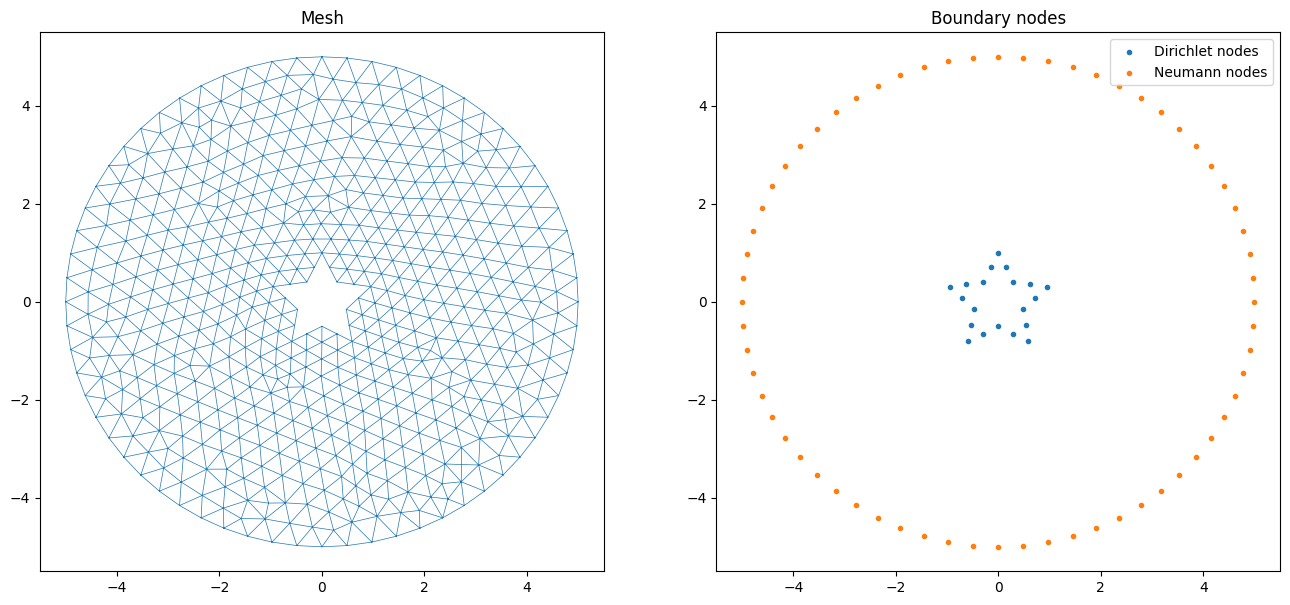

In [15]:
fem.plot_mesh(size=(8,7), plot_bd=True)

In [16]:
# fem.build_local_Sk_innerProds(a=None)

In [17]:
fem.assemble_system()

In [18]:
fem.solve()

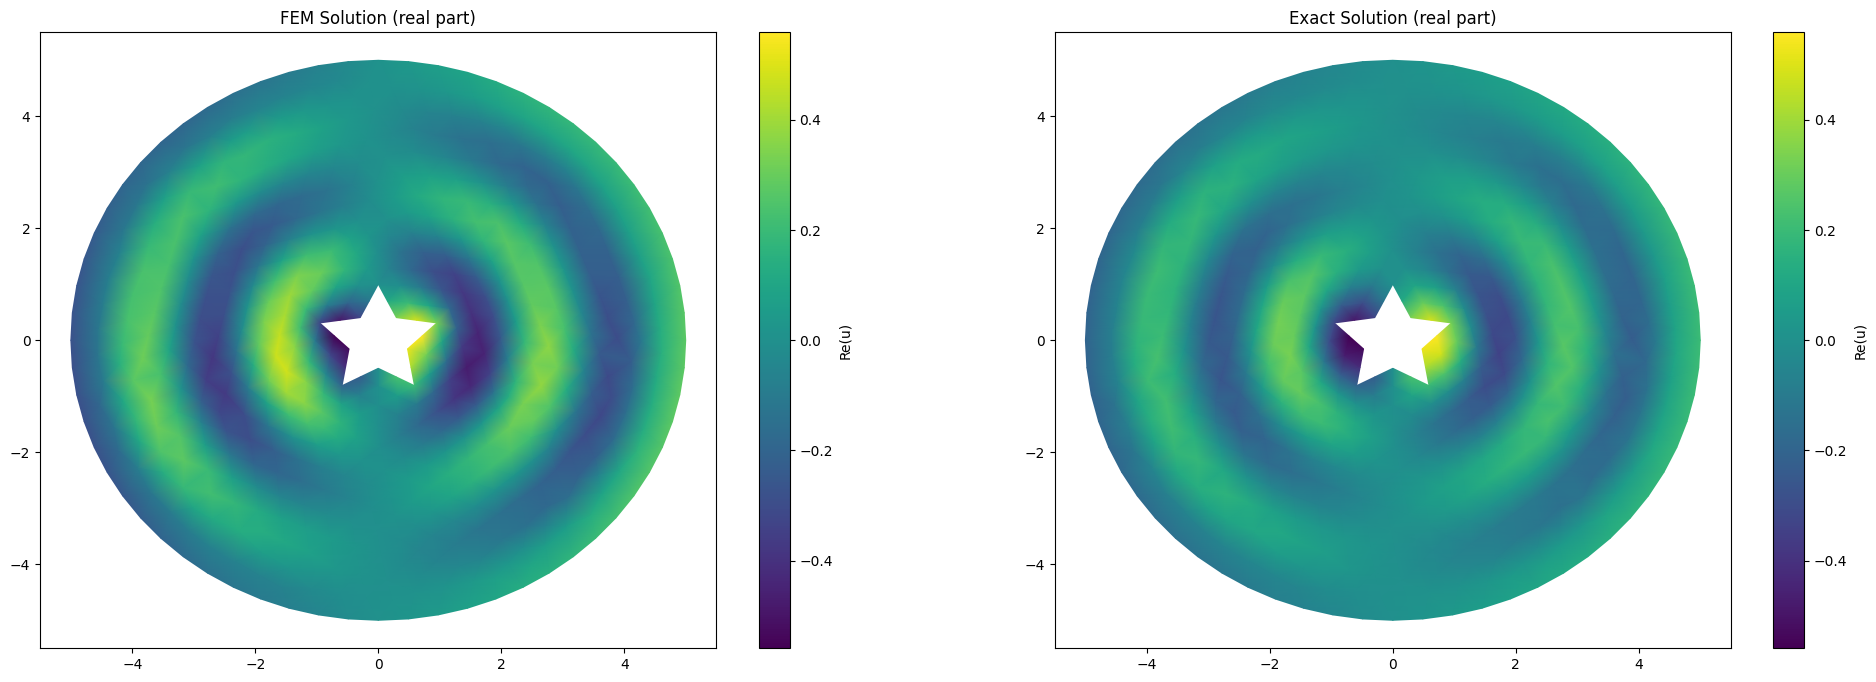

In [19]:
fem.plot_solution(real_part=True)

h = 0.50000 | L2 error = 5.668e-01, H1 error = 1.715e+00
h = 0.25000 | L2 error = 1.480e-01, H1 error = 4.559e-01
h = 0.10000 | L2 error = 2.467e-02, H1 error = 7.825e-02
h = 0.05000 | L2 error = 6.231e-03, H1 error = 2.043e-02


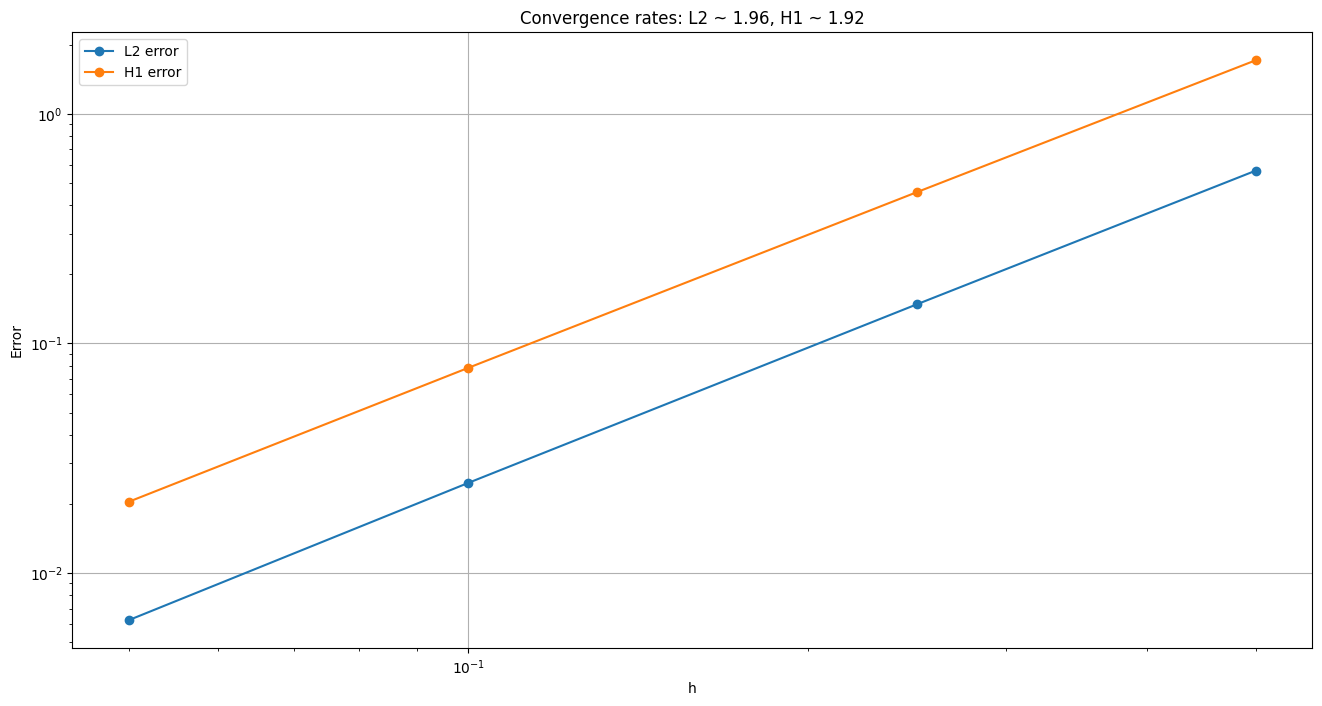

In [20]:
L2_errors = []
H1_errors = []
hs = []

for h in [0.5, 0.25, 0.1, 0.05]:  # refinement loop
    fem = HelmholtzFEM(h=h)
    fem.generate_mesh()
    fem.assemble_system()
    fem.solve()
    L2_err, H1_err = fem.compute_errors()
    L2_errors.append(L2_err)
    H1_errors.append(H1_err)
    hs.append(h)
    print(f"h = {h:.5f} | L2 error = {L2_err:.3e}, H1 error = {H1_err:.3e}")

# Plot convergence
plt.figure(figsize=(16,8))
plt.loglog(hs, L2_errors, '-o', label='L2 error')
plt.loglog(hs, H1_errors, '-o', label='H1 error')

# Fit slopes
p_L2 = np.polyfit(np.log(hs), np.log(L2_errors), 1)[0]
p_H1 = np.polyfit(np.log(hs), np.log(H1_errors), 1)[0]
plt.legend()
plt.xlabel("h")
plt.ylabel("Error")
plt.title(f"Convergence rates: L2 ~ {p_L2:.2f}, H1 ~ {p_H1:.2f}")
plt.grid(True)
plt.show()
